In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from spatialinfo import spatial_information as si
from pathlib import Path
from datetime import datetime
import math
import seaborn as sns
from scipy import stats
import scipy.cluster.hierarchy as hac


# Activity patterns in the anterolateral Dl region

Neurons in alDl are characterized by high baseline activity. This holds true even in ex-vivo preps (Emre Yaksi, personal communication). Based on manual inspection of the activity traces, it seemed that activity is modulated by behavior of the animals in the VR. This notebook is intended to investigate this possibility. 

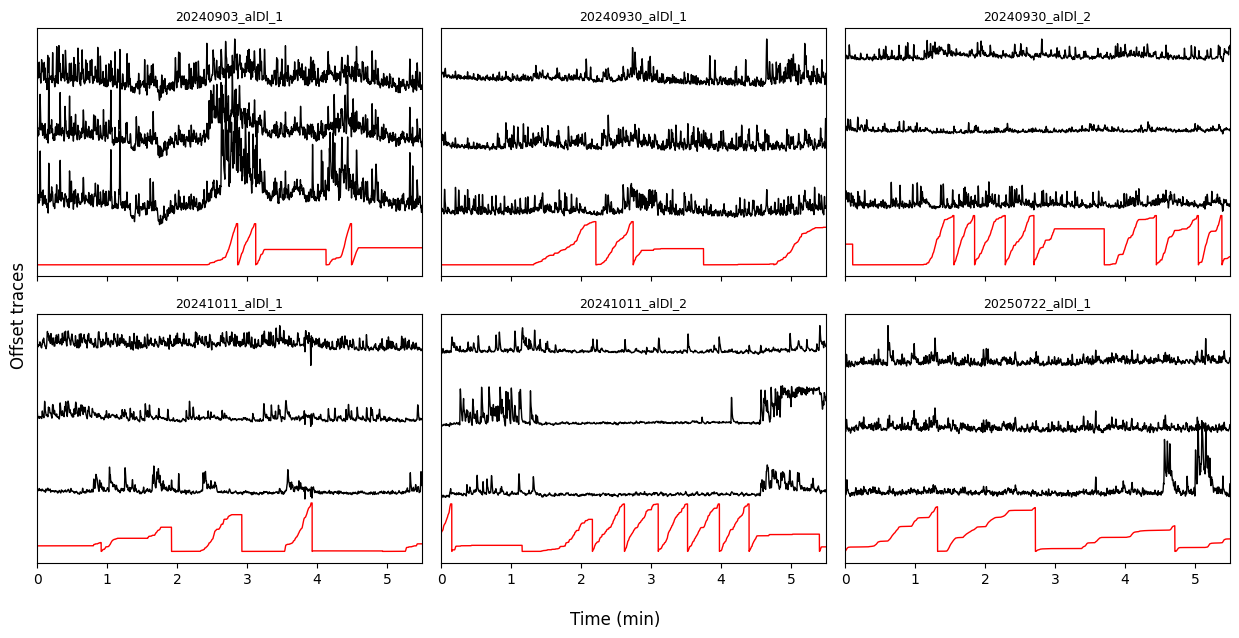

In [2]:
data_path = Path('..\\data\\processed_datasets\\')
alDl_folders = ['20240903_alDl_1',
                '20240930_alDl_1',
                '20240930_alDl_2',
                '20241011_alDl_1',
                '20241011_alDl_2',
                '20250722_alDl_1']

# figure grid: as square as possible
n = len(alDl_folders)
ncols = math.ceil(math.sqrt(n))
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4.2 * ncols, 3.2 * nrows), sharex=True)
axes = np.atleast_1d(axes).ravel()

x = np.linspace(0, 5.5, 10000)

for ax, item in zip(axes, alDl_folders):
    dff, bh = si.load_data(Path(data_path, Path(item)))

    # choose branch based on date
    if datetime.strptime(item.split('_')[0], '%Y%m%d') > datetime.strptime('20250701', '%Y%m%d'):
        bh.columns = ['timestamp', 'trial', 'trial index', 'X', 'Y', 'velocity', 'tail tracking framecount']
    else:
        bh = si.remove_interpolated_values(bh, n_corr=2)
        bh = si.add_trial_column(bh)

    # plot behavior (Y) normalized and offset
    y = bh['Y'].to_numpy()[:10000]
    ax.plot(x, y / np.nanmax(y) - 1.2, 'r', linewidth=1, label='Y (norm)')

    # plot a few dFF traces with offsets
    for i in range(3, 6):
        ax.plot(x, dff.iloc[:10000, i].to_numpy() + 1.5 * (i - 3), 'k', linewidth=1)

    ax.set_title(item, fontsize=9)
    ax.set_xlim(0, 5.5)
    ax.set_yticks([])

# hide any leftover empty axes
for j in range(len(alDl_folders), len(axes)):
    axes[j].axis('off')

fig.supxlabel('Time (min)')
fig.supylabel('Offset traces')
fig.tight_layout()
plt.show()
        

## Neural activity description

In [3]:
dff.shape

(54000, 187)

## Modulation by motion and environment

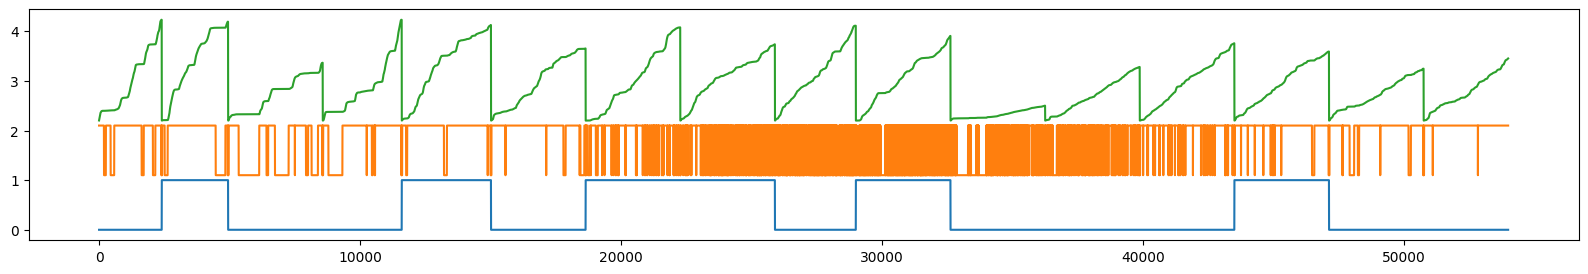

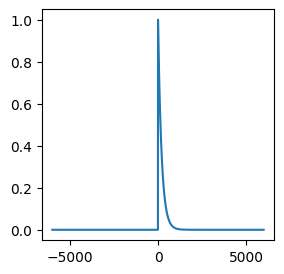

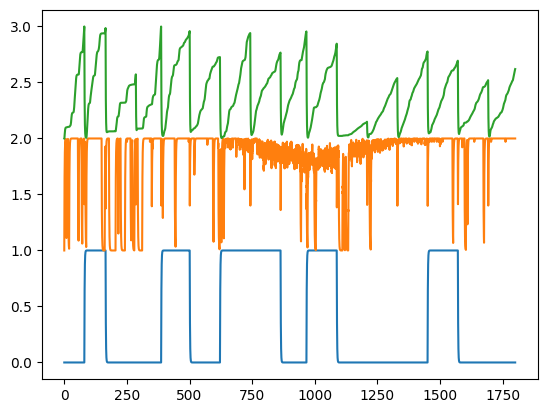

In [14]:
# create regressors for corridor (boolean), movement, and position within corridor
corr_reg = bh["X"] == 0 
move_reg = bh["Y"].diff() != 0
pos_reg = bh["Y"]

plt.figure(figsize=(20,3))
plt.plot(corr_reg)
plt.plot(move_reg +1.1)
plt.plot(pos_reg + 2.2)

import math
exp_t=np.zeros((2000))
exp_k=np.zeros((2000))
for i in range(2000):
    exp_t[i]=6*i-6000
    exp_k[i]=math.exp(-(6*i-6000)/200)
exp_k[exp_t<0]=0
plt.figure(figsize=(3,3))
plt.plot(exp_t,exp_k)
plt.show()

num_regressors=3
Reg=np.empty((num_regressors,dff.shape[0]))
Reg[0,:]=np.convolve(corr_reg,exp_k,'same')
Reg[1,:]=np.convolve(move_reg,exp_k,'same')
Reg[2,:]=np.convolve(pos_reg,exp_k,'same')

time_seconds= np.linspace(0, dff.shape[0], len(dff))/30

int_Reg=np.zeros([num_regressors,dff.shape[0]])
from scipy import interpolate

plt.figure()
for j in range(num_regressors):
    f=interpolate.interp1d(time_seconds,Reg[j,:])
    int_Reg[j,:]=f(time_seconds)
    int_Reg[j,:]=int_Reg[j,:]/(np.max(np.abs(int_Reg[j,:])))
    plt.plot(time_seconds,int_Reg[j]+j)

[None]

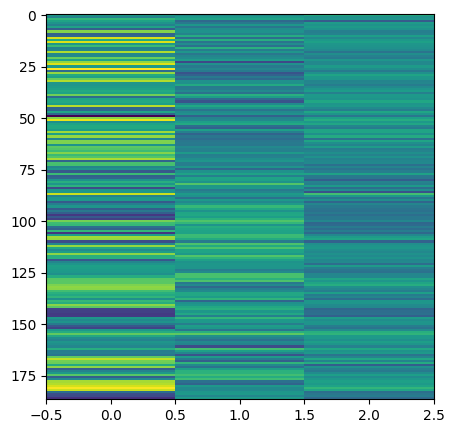

In [15]:
from scipy.stats import pearsonr
all_correlations=np.zeros([num_regressors,dff.shape[1]])
for k in range(num_regressors):
    for j in range(dff.shape[1]):
        C,_=pearsonr(int_Reg[k,:],dff.iloc[:,j])
        all_correlations[k,j]=C
        
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.imshow(np.transpose(all_correlations), interpolation="None")
ax.set(aspect="auto")

In [ ]:
plt.figure(figsize=(10,10))
for k in range(num_regressors):
    id=np.argmax(all_correlations[k,:])
   
    print(id)
    Y=dff.iloc[:,id]
    Y=Y-np.min(Y)
    Y=Y/np.max(Y)
    plt.plot(time_seconds,int_Reg[k,:]-1.5*k, 'r')
    plt.plot(time_seconds,Y-1.5*k, linewidth = 0.8)
    
plt.show()



Regressor 0, Correlation Rank 1: Index 26, Correlation 0.318
Regressor 0, Correlation Rank 2: Index 181, Correlation 0.313
Regressor 0, Correlation Rank 3: Index 51, Correlation 0.299
Regressor 0, Correlation Rank 4: Index 13, Correlation 0.287
Regressor 0, Correlation Rank 5: Index 24, Correlation 0.285
Regressor 1, Correlation Rank 1: Index 155, Correlation 0.162
Regressor 1, Correlation Rank 2: Index 117, Correlation 0.151
Regressor 1, Correlation Rank 3: Index 82, Correlation 0.151
Regressor 1, Correlation Rank 4: Index 100, Correlation 0.148
Regressor 1, Correlation Rank 5: Index 129, Correlation 0.146
Regressor 2, Correlation Rank 1: Index 87, Correlation 0.132
Regressor 2, Correlation Rank 2: Index 181, Correlation 0.107
Regressor 2, Correlation Rank 3: Index 155, Correlation 0.103
Regressor 2, Correlation Rank 4: Index 154, Correlation 0.088
Regressor 2, Correlation Rank 5: Index 131, Correlation 0.085


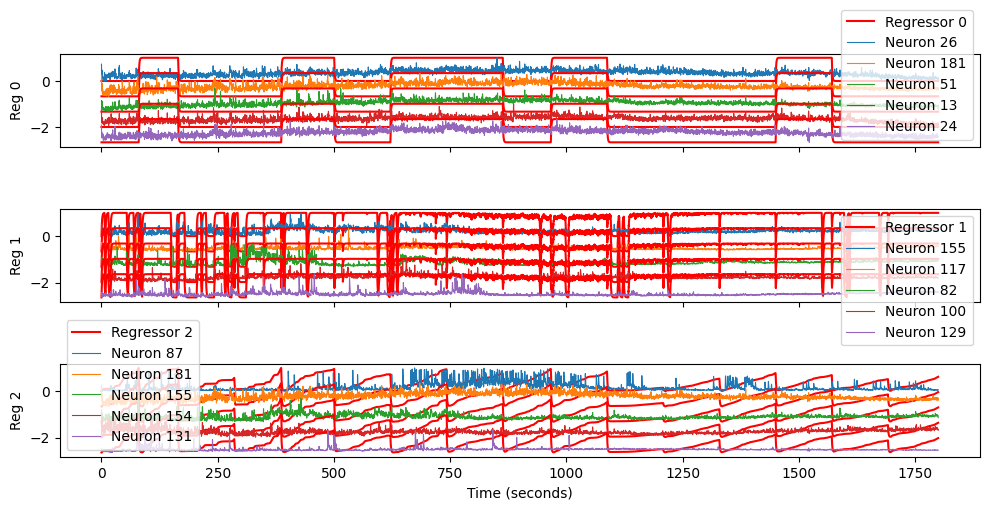

In [24]:
from sklearn.linear_model import LinearRegression
def get_regscores(traces, reg, regexzero = True, lim=None):
    if regexzero:
        #define boolean in case you only want to correlate nonzero parts of regressor
        rbool = np.where(reg!=0)
        lreg = LinearRegression().fit(reg.T.reshape(-1, 1)[rbool], traces.iloc[rbool])
    else:
        lreg = LinearRegression().fit(reg.T.reshape(-1, 1), self.traces[:, :lim].T)

    rsme = np.nanmean(((traces.T.iloc[:lim,:] - reg) ** 2) ** 0.5, axis=1).reshape(-1, 1)
    v = ((reg - reg.mean()) ** 2).sum()
    r2 = 1 - (rsme / v)
    #r2[np.isinf(np.array(r2))] = 0
    coefs = lreg.coef_
    #this score takes into account both the goodness-of-fit and the regression slope
    scr = coefs * r2
    scores = np.concatenate([scr, coefs], axis=1)
    return scores

# Set the number of top correlations to display
x = 5

# Create subplots for each regressor
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

# Iterate over each regressor type
for k in range(3):
    ax = axes[k]  # Select the subplot for the current regressor
    
    # Get the indices of the top x correlations for the current regressor
    top_indices = np.argsort(all_correlations[k, :])[-x:][::-1]

    # Plot each of the top x correlations
    for i, idx in enumerate(top_indices):
        print(f"Regressor {k}, Correlation Rank {i+1}: Index {idx}, Correlation {all_correlations[k, idx]:.3f}")
        
        # Extract and normalize the corresponding data
        Y = dff.iloc[:, idx]
        Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

        # Plot the regressor and the normalized trace
        ax.plot(time_seconds, int_Reg[k, :] - 3.3 * (i / x), 'r', label=f'Regressor {k}' if i == 0 else "")
        ax.plot(time_seconds, Y - 3.3 * (i / x), linewidth=0.8, label=f'Neuron {idx}')

    # Add labels and legend to each subplot
    ax.set_ylabel(f'Reg {k}')
    if k == 2:
        ax.set_xlabel('Time (seconds)')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [41]:
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
# from statsmodels.robust.scale import mad  # pip install statsmodels (or replace with np.median(abs(x - med)) / 0.6745)
import matplotlib.pyplot as plt

def butter_lowpass(x, fs, cutoff=8.0, order=2):
    if cutoff is None:
        return x
    b, a = butter(order, Wn=cutoff/(fs/2), btype='low')
    return filtfilt(b, a, x, axis=0)

def robust_zscore(x):
    med = np.median(x)
    m = np.median(abs(x - med)) / 0.6745  # consistent with normal, returns ~1.4826*MAD; fine for thresholding
    return (x - med) / (m if m > 1e-12 else 1.0)

def event_triggered_average(
    dff, fs, pre_s=1.0, post_s=1.0,
    thr_z=3.0, min_prom=0.3, min_distance_s=0.4,
    lp_cutoff=None, normalize_to_peak=False, return_snippets=False
):
    """
    dff: array (T, N) or (T,) dF/F traces
    fs: sampling rate (Hz)
    pre_s, post_s: window lengths around peak (seconds)
    thr_z: robust z-score threshold on each neuron's trace (after optional filtering)
    min_prom: minimum prominence in dF/F units (applied before baseline subtraction)
    min_distance_s: refractory period for peaks
    lp_cutoff: low-pass cutoff in Hz (e.g., 8 for GCaMP6/7; None disables filtering)
    normalize_to_peak: if True, normalize each snippet so its peak is 1 after baseline subtraction
    return_snippets: if True, also return list of all snippets per neuron
    """
    X = np.atleast_2d(dff)
    if X.shape[0] < X.shape[1]:  # ensure (T, N)
        X = X.T
    T, N = X.shape

    # optional light smoothing
    Xf = butter_lowpass(X, fs, cutoff=lp_cutoff, order=2) if lp_cutoff else X

    pre = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    win_len = pre + post + 1
    t = (np.arange(win_len) - pre) / fs

    means = np.full((win_len, N), np.nan)
    sems  = np.full((win_len, N), np.nan)
    all_snips = [] if return_snippets else None

    for n in range(N):
        x = Xf[:, n]
        # robust thresholding on z-scored trace
        z = robust_zscore(x)
        peaks, props = find_peaks(
            x,  # use raw or filtered signal for peaks; we keep z to gate
            distance=int(round(min_distance_s * fs)),
            prominence=min_prom
        )
        # keep only peaks whose z-score exceeds thr_z
        keep = peaks[z[peaks] >= thr_z]
        # collect snippets
        snips = []
        for p in keep:
            if p - pre < 0 or p + post >= T:
                continue
            s = x[p - pre : p + post + 1].copy()
            # baseline: mean of pre-window
            base = np.nanmean(s[:pre]) if pre > 0 else 0.0
            s = s - base
            if normalize_to_peak:
                pk = np.nanmax(s)
                if pk > 1e-12:
                    s = s / pk
            snips.append(s)

        if len(snips) >= 1:
            S = np.vstack(snips)
            means[:, n] = np.nanmean(S, axis=0)
            # avoid dividing by zero if only one snippet
            sems[:, n]  = np.nanstd(S, axis=0, ddof=1) / np.sqrt(S.shape[0]) if S.shape[0] > 1 else 0.0
            if return_snippets:
                all_snips.append(S)
        elif return_snippets:
            all_snips.append(np.empty((0, win_len)))

    return t, means, sems, all_snips

# ---- Example usage & plotting ----
# dff: (T, N) ndarray; fs: float (Hz)
t, mean_wf, sem_wf, _ = event_triggered_average(dff, fs=30.0, pre_s=1.0, post_s=1.0,
                                                 thr_z=3.0, min_prom=0.2, min_distance_s=0.5,
                                                 lp_cutoff=8.0, normalize_to_peak=False)
# Plot first 6 neurons:
# k = min(6, mean_wf.shape[1])
# fig, axs = plt.subplots(1, k, figsize=(4*k, 3), sharey=True)
# for i in range(k):
#     axs[i].plot(t, mean_wf[:, i], linewidth=1.5)
#     axs[i].fill_between(t, mean_wf[:, i]-sem_wf[:, i], mean_wf[:, i]+sem_wf[:, i], alpha=0.25)
#     axs[i].axvline(0, ls='--', lw=1)
#     axs[i].set_title(f'Neuron {i}')
# axs[0].set_ylabel('dF/F (baseline-subtracted)')
# for ax in axs: ax.set_xlabel('Time (s)')
# fig.suptitle('Typical depolarization waveform (event-triggered average)')
# fig.tight_layout()
# plt.show()


TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method